In [0]:
# CDI for normalized total spending

In [0]:
from pyspark.sql.functions import countDistinct, col, sum as sum_, concat, lit, year, month, length
import matplotlib.dates as mdates
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import logging
from datetime import timedelta, datetime
from pytz import timezone
import pandas as pd
import pickle
from scipy.stats import norm
import re
logger = spark._jvm.org.apache.log4j
logging.getLogger("py4j").setLevel(logging.ERROR)

In [0]:
event_data_delta_file_path = "/mnt/delta/general_data/Disqo_Dataset_Processed_Delta/retailers_us_with_levels"
event_data_df = spark.read.option("header", "true").format("delta").load(event_data_delta_file_path)
event_data_df = event_data_df.withColumn("ds", event_data_df.timestamp.cast('date'))
event_data_df = event_data_df.withColumn("date_year", year(col('date')))
event_data_df = event_data_df.withColumn("date_month", month(col('date')))

In [0]:
# pull demographic data table and weights table 

main_demo_data_delta_file_path = "/mnt/delta/general_data/Disqo_Dataset_Processed_Delta/dashboard_demo_data"
demo_data = spark.read.option("header", "true").format("delta").load(main_demo_data_delta_file_path)

weighting_file_path = "/mnt/delta/general_data/Disqo_Dataset_Processed_Delta/monthly_weighting_dictionary"
weighting_df = spark.read.option("header", "true").format("delta").load(weighting_file_path)

In [0]:
# Level1
filtered_event_data_df = event_data_df.withColumn("category", col("level_0"))

# here addToCart is as the proxy of checkOut as data between Sep and Dec seems to be broken
filtered_event_data_df = filtered_event_data_df.filter(
                                              (((filtered_event_data_df.event_name == 'orderPlaced') & (filtered_event_data_df.page_domain == 'walmart.com')) |\
                                              ((filtered_event_data_df.event_name == 'addToCart') & (filtered_event_data_df.page_domain != 'walmart.com')))& \
                                              (filtered_event_data_df.category.isNotNull())& \
                                             (filtered_event_data_df.price.isNotNull()) & \
                                             (filtered_event_data_df.quantity.isNotNull()))

# add demo information
filtered_event_data_df = filtered_event_data_df.join(demo_data, ['user_id'])

# add weight information
filtered_event_data_df = filtered_event_data_df.join(weighting_df, ['date_year', 'date_month', 'state', 'gender', 'age_group','ethnicity'])

# for normal case
filtered_event_data_df = filtered_event_data_df.select(
                                                       col("user_id"),
                                                       col("ds"),
                                                       col("quantity"), 
                                                       col("price"), 
                                                       col("category"),
                                                       col("weights"))

filtered_event_data_df = filtered_event_data_df.withColumn("total_amount_weighted", col("price")*col("quantity")*col("weights"))
filtered_event_data_df = filtered_event_data_df.withColumn("total_amount", col("price")*col("quantity"))


category_amount_df = filtered_event_data_df.groupBy("ds", "category").agg(sum_("total_amount").alias("daily_total_spent"), sum_("total_amount_weighted").alias("daily_total_spent_weighted"))

event_data_by_day_df = category_amount_df.withColumn("y", col("daily_total_spent_weighted"))

event_data_by_day_df = event_data_by_day_df.filter((event_data_by_day_df.category.isNotNull()) & (length(event_data_by_day_df.category)>0))
event_data_by_day_pandas = event_data_by_day_df.toPandas()
event_data_by_day_pandas['ds'] = event_data_by_day_pandas['ds'].apply(lambda x: pd.to_datetime(x))

In [0]:
com = event_data_by_day_pandas[(event_data_by_day_pandas.category == 'sports & outdoors')][['ds', 'daily_total_spent_weighted']]
com['year'] = com.apply(lambda x: str(x['ds'].year), axis=1)
computers = com[com.daily_total_spent_weighted < com.daily_total_spent_weighted.quantile(0.95)]
computers.groupby('year').sum('daily_total_spent_weighted')

Out[7]:

,daily_total_spent_weighted
year,
2020,8.022412e+09
2021,6.035684e+09
2022,6.969833e+09


Out[8]:

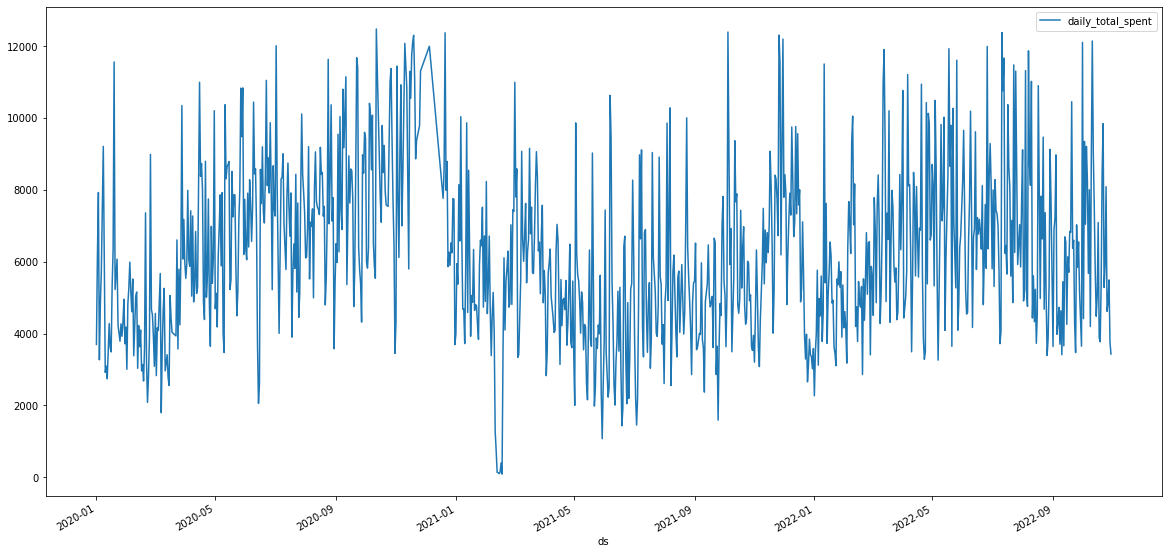

<AxesSubplot:xlabel='ds'>

In [0]:
c= 'toys & games'
# com = event_data_by_day_pandas[event_data_by_day_pandas.category == c][['ds' ,'daily_total_spent']]
# com['date'] = com.apply(lambda x: str(x['ds'].year) + str(x['ds'].month) if len(str(x['ds'].month)) > 1 else str(x['ds'].year) + '0'+str(x['ds'].month), axis=1)
# computers = com[com.daily_total_spent < com.daily_total_spent.quantile(0.95)]
# computers = com.groupby('date').agg({'daily_total_spent':'sum'}).reset_index()
# computers = computers.sort_values('date')
# computers.plot(x='date', y='daily_total_spent', figsize=(20, 10))


com = event_data_by_day_pandas[event_data_by_day_pandas.category == c][['ds' ,'daily_total_spent']]
com['date'] = com.apply(lambda x: str(x['ds'].year) + str(x['ds'].month) if len(str(x['ds'].month)) > 1 else str(x['ds'].year) + '0'+str(x['ds'].month), axis=1)
computers = com[com.daily_total_spent < com.daily_total_spent.quantile(0.95)]
# computers = com.groupby('date').agg({'daily_total_spent':'sum'}).reset_index()
computers = computers.sort_values('ds')
computers.plot(x='ds', y='daily_total_spent', figsize=(20, 10))

Out[9]:

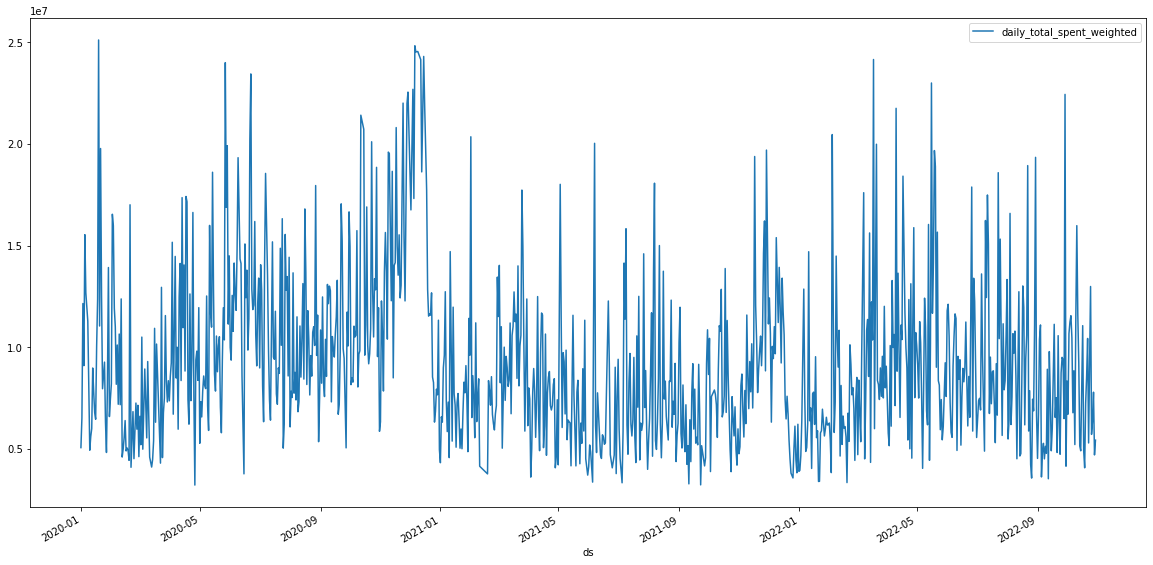

<AxesSubplot:xlabel='ds'>

In [0]:
# com = event_data_by_day_pandas[event_data_by_day_pandas.category == c][['ds', 'daily_total_spent_weighted']]
# com['date'] = com.apply(lambda x: str(x['ds'].year) + str(x['ds'].month) if len(str(x['ds'].month)) > 1 else str(x['ds'].year) + '0'+str(x['ds'].month), axis=1)

# computers = com[(com.daily_total_spent_weighted >= com.daily_total_spent_weighted.quantile(0.025)) & (com.daily_total_spent_weighted <= com.daily_total_spent_weighted.quantile(0.975))]
# computers = com.groupby('date').agg({'daily_total_spent_weighted':'sum'}).reset_index()
# computers = computers.sort_values('date')
# computers.plot(x='date', y='daily_total_spent_weighted', figsize=(20, 10))

com = event_data_by_day_pandas[event_data_by_day_pandas.category == c][['ds', 'daily_total_spent_weighted']]
com['date'] = com.apply(lambda x: str(x['ds'].year) + str(x['ds'].month) if len(str(x['ds'].month)) > 1 else str(x['ds'].year) + '0'+str(x['ds'].month), axis=1)
computers = com[(com.daily_total_spent_weighted >= com.daily_total_spent_weighted.quantile(0.025)) & (com.daily_total_spent_weighted <= com.daily_total_spent_weighted.quantile(0.975))]
# computers = com.groupby('date').agg({'daily_total_spent_weighted':'sum'}).reset_index()
computers = computers.sort_values('ds')
computers.plot(x='ds', y='daily_total_spent_weighted', figsize=(20, 10))

In [0]:
# Probability density formula of normal distribution.
def normal_dist(x , mean , sd):
    prob_density = 1/(sd * np.sqrt(2 * np.pi)) *np.exp( - (x - mean)**2 / (2 * sd**2))
    return prob_density
  
def compute_unexcepted_score(upper_standard_unexcepted_score, lower_standard_unexcepted_score, x, upper, lower):
    if x-upper > upper_standard_unexcepted_score:
      return upper_standard_unexcepted_score
    elif x-upper > 0:
      return x-upper
    elif lower-x > lower_standard_unexcepted_score:
      return -lower_standard_unexcepted_score
    elif lower-x > 0:
      return -(lower-x)
    else:
      return 0
    
def modeling_graphing(df, category, spliting_date, projection_end_date, sigma, state, prediction_window, covid_cutoff):
  projection_end_date = pd.to_datetime(projection_end_date) 
  year, month = projection_end_date.year, projection_end_date.month
  projection_start_date = projection_end_date - timedelta(days=prediction_window) + timedelta(days=1)
  fig_startdate = projection_end_date - timedelta(days=700)
  
  spliting_date = pd.to_datetime(spliting_date)
  
  train_df = None
  if covid_cutoff:
    train_df = df[(df.ds >= pd.to_datetime('2020-03-01')) & (df.ds <= spliting_date)]
  else:
    train_df = df[(df.ds <= spliting_date)]
  lower_quantile, upper_quantile = train_df.y.quantile(0.025), train_df.y.quantile(0.975)
  mean, std = train_df.y.mean(), train_df.y.std()

  train_df =  train_df[(train_df.y >= lower_quantile) & (train_df.y <= upper_quantile)]
  # adding minnimum value to saturate
  train_df['floor'] = 0.0
  test_df = df[(df.ds > spliting_date)]  
  if train_df.shape[0] < 90:
    print("Too much less data point ({})to analyze.".format(train_df.shape[0]))
    return None, None
  
  # specify model path
  formated_category = re.sub(r'[^a-zA-Z\s]', '', category)
  formated_category = re.sub(r'[^\S\n\t]+', '_', formated_category)
  model_pkl_path = "/dbfs/mnt/delta/general_data/disqo_CDI_models/" + formated_category + ' '+ str(year) + '_' + str(month) + " weighted_total_spent_trained_dashboard.pkl"
  
  # Add holidays:
  lockdown_system_downtime = pd.DataFrame([
      {'holiday': 'lockdown_1', 'ds': '2020-03-01', 'lower_window': 0, 'ds_upper': '2020-05-01'},
      {'holiday': 'disqo_pipeline_break', 'ds': '2021-02-10', 'lower_window': 0, 'ds_upper': '2021-02-17'}, 
  ])
  for t_col in ['ds', 'ds_upper']:
      lockdown_system_downtime[t_col] = pd.to_datetime(lockdown_system_downtime[t_col])
  lockdown_system_downtime['upper_window'] = (lockdown_system_downtime['ds_upper'] - lockdown_system_downtime['ds']).dt.days
  
# Model Generation and Save
# **************************************************************** #
  if state == 'model':
    
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.0005, interval_width=sigma, holidays=lockdown_system_downtime)
    m.add_country_holidays(country_name='US')
    m.fit(train_df)

    with open(model_pkl_path, "wb") as f:
        pickle.dump(m, f)
    f.close()
# # **************************************************************** #
  elif state == 'graph':
# Load Saved Models and Predict
# **************************************************************** #
    with open(model_pkl_path, 'rb') as f:
      m = pickle.load(f)
    f.close()
    # prediction and select the data within the testing window
    # **************************************************************** #
    future = m.make_future_dataframe(periods=(projection_end_date- train_df['ds'].max()).days)
    future['floor'] = 0.0
    forecast = m.predict(future)
    forecast = forecast.merge(df, left_on="ds", right_on="ds", how="left")
    # exclude outliers (within the prediiction window)
    forecast =  forecast[(forecast.y >= mean - 3*std) & (forecast.y <= mean + 3*std)]
    
    projection_start_date = projection_end_date - timedelta(days=prediction_window)
    window_forecast = forecast[(forecast.ds > projection_start_date) & (forecast.ds <= projection_end_date)]
    
    # calculate weighted comsumption deviation index
    # **************************************************************** #
    window_forecast['upper_standard_unexcepted_score_capacity'] = window_forecast.apply(lambda row: norm(loc = row['yhat'] , scale = (row['yhat_upper']-row['yhat_lower'])/2).ppf(.99) - row['yhat_upper'], axis=1)
    window_forecast['lower_standard_unexcepted_score_capacity'] = window_forecast.apply(lambda row: row['yhat_lower'] - norm(loc = row['yhat'] , scale = (row['yhat_upper']-row['yhat_lower'])/2).ppf(0.01), axis=1)
    window_forecast['unexpected_score'] = window_forecast.apply(lambda row: compute_unexcepted_score(row['upper_standard_unexcepted_score_capacity'], row['lower_standard_unexcepted_score_capacity'], row['y'], row['yhat_upper'], row['yhat_lower']), axis=1)
    weighted_CDI = round(100*(window_forecast['unexpected_score'].sum()) / ((window_forecast['upper_standard_unexcepted_score_capacity'].mean()+window_forecast['lower_standard_unexcepted_score_capacity'].mean())/2*window_forecast.shape[0]), 1)
    
    # calculate comsumer inpact index
    # **************************************************************** #
    window_forecast['upper_outlier'] = window_forecast['y'] >  window_forecast['yhat_upper']
    window_forecast['lower_outlier'] = window_forecast['y'] < window_forecast['yhat_lower']
  
    num_upper_outlier = window_forecast['upper_outlier'].sum()
    num_lower_outlier = window_forecast['lower_outlier'].sum()
    CDI = round(((num_upper_outlier - num_lower_outlier)*1.0 /window_forecast.shape[0])*100, 2) 
    
    df_to_save = forecast[forecast.ds > fig_startdate][['category', 'ds', 'yhat_lower', 'yhat_upper', 'yhat', 'daily_total_spent_weighted']]
    df_to_save['category'] = category
    df_to_save['target_year'] = year
    df_to_save['target_month'] = month
    df_to_save['ds'] = df_to_save['ds'].apply(lambda x: x.date())
    return {'category' : category,  'target_year': year,  'target_month': month, "monthly_CDI": CDI, "weighted_monthly_CDI": weighted_CDI}, df_to_save

In [0]:
categories = list(event_data_by_day_pandas['category'].unique())
categories

Out[11]: ['industrial & scientific',
 'electronics',
 'pet supplies',
 'appliances',
 'health & personal care',
 'tools & home improvement',
 'entertainment',
 'toys & games',
 'automotive',
 'home & kitchen',
 'clothing, shoes & jewelry',
 'beauty',
 'arts, crafts & sewing',
 'grocery & gourmet food',
 'sports & outdoors',
 'office products',
 'patio, lawn & garden',
 'baby',
 'handmade',
 'gift cards & tickets']

In [0]:
target_window = 30
prediction_window = 90
sigma = 0.6826
stats_list = []
charts_df = pd.DataFrame()

# split_date = (datetime.now().astimezone(timezone('US/Pacific')) - timedelta(days=prediction_window)).strftime("%m/%d/%Y")
# prediction_end_date = (datetime.now().astimezone(timezone('US/Pacific')) - timedelta(days=1)).strftime("%m/%d/%Y")
for month in ['11']:
  split_date = (pd.to_datetime('2022-'+month+'-01')  - timedelta(days=prediction_window)).strftime("%m/%d/%Y")
  prediction_end_date = (pd.to_datetime('2022-'+month+'-01') - timedelta(days=1)).strftime("%m/%d/%Y")

  # Trainining
  # **********************************************
  for category in categories:
      print("modeling time sieries for {}".format(category))
      modeling_graphing(event_data_by_day_pandas[event_data_by_day_pandas.category == category], category, split_date, prediction_end_date, sigma, 'model', prediction_window, True)
  # **********************************************
  # Predicting
  # **********************************************
  for category in categories:
    CDI_stat, chart_df = modeling_graphing(event_data_by_day_pandas[event_data_by_day_pandas.category == category], category, split_date, prediction_end_date, sigma,  'graph', prediction_window, True)
    if CDI_stat is not None:
      stats_list.append(CDI_stat)
      charts_df = pd.concat([charts_df, chart_df])
  # **********************************************

modeling time sieries for industrial & scientific
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
modeling time sieries for electronics
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for pet supplies
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for appliances
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for health & personal care
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
modeling time sieries for tools & home improvement
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for entertainment
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
modeling time sieries for toys & games
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for automotive
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
modeling time sieries for home & kitchen
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for clothing, shoes & jewelry
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
modeling time sieries for beauty
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
modeling time sieries for arts, crafts & sewing
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for grocery & gourmet food
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for sports & outdoors
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for office products
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for patio, lawn & garden
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for baby
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
modeling time sieries for handmade
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING:fbprophet.models:Optimization terminated abnormally. Falling back to Newton.
modeling time sieries for gift cards & tickets
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<command-3979876106195885>:88: SettingWithCopyWarning: 
A value is trying to be set on a co

In [0]:
cdi_chart_table_file_path = '/mnt/delta/general_data/CDI/all_retailers_cdi_chart_table'
cdi_result_table_file_path = '/mnt/delta/general_data/CDI/all_retailers_cdi_stats_table'

cdi_result_spark_df = spark.createDataFrame(pd.DataFrame.from_records(stats_list))
charts_spark_df = spark.createDataFrame(charts_df)

# this is for initiation 
# dbutils.fs.rm(cdi_result_table_file_path, True)
# dbutils.fs.rm(cdi_chart_table_file_path, True)
# cdi_result_spark_df.write.format("delta").save(cdi_result_table_file_path)
# charts_spark_df.write.format("delta").save(cdi_chart_table_file_path)

# # for update
cdi_result_spark_df.write.format("delta").mode('append').save(cdi_result_table_file_path)
charts_spark_df.write.format("delta").mode('append').save(cdi_chart_table_file_path)

In [0]:
%sql
drop table if exists disqo_dashboard_db.all_retailers_cdi_chart;
CREATE TABLE disqo_dashboard_db.all_retailers_cdi_chart
USING delta
LOCATION "/mnt/delta/general_data/CDI/all_retailers_cdi_chart_table"

In [0]:
%sql
drop table if exists  disqo_dashboard_db.all_retailers_cdi_stats;
CREATE TABLE disqo_dashboard_db.all_retailers_cdi_stats
USING delta
LOCATION '/mnt/delta/general_data/CDI/all_retailers_cdi_stats_table'